In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
retail=pd.read_csv('/content/drive/MyDrive/retail_sales_dataset.csv')

In [14]:
retail.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [15]:
retail.describe()

,Transaction ID,Age,Quantity,Price per Unit,Total Amount
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,500.500000,41.39200,2.514000,179.890000,456.000000
std,288.819436,13.68143,1.132734,189.681356,559.997632
min,1.000000,18.00000,1.000000,25.000000,25.000000
25%,250.750000,29.00000,1.000000,30.000000,60.000000
50%,500.500000,42.00000,3.000000,50.000000,135.000000
75%,750.250000,53.00000,4.000000,300.000000,900.000000
max,1000.000000,64.00000,4.000000,500.000000,2000.000000


In [16]:
retail.isnull().sum()

,0
Transaction ID,0
Date,0
Customer ID,0
Gender,0
Age,0
Product Category,0
Quantity,0
Price per Unit,0
Total Amount,0


<Axes: >

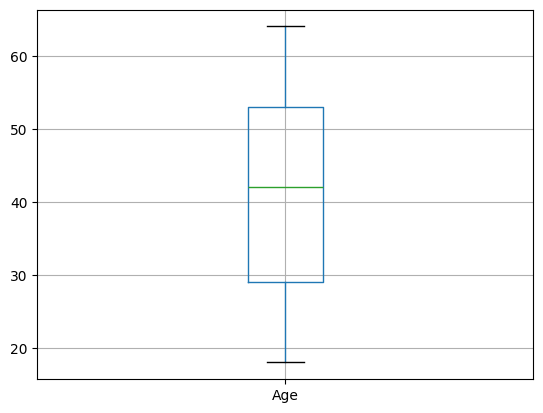

In [17]:
#Customer and Product Analysis
retail.boxplot(column='Age')

In [18]:
unique = retail['Product Category'].unique()
for category in unique:
  print(category)

Beauty
Clothing
Electronics


Text(0.5, 1.0, 'Age distribution by product category')

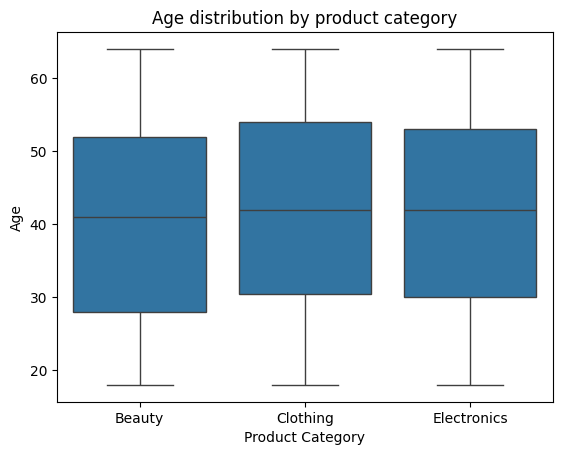

In [19]:
sns.boxplot(x=retail['Product Category'],
      y=retail['Age'],data=retail).set_title('Age distribution by product category')

array([<Axes: title={'center': 'Female'}>,
       <Axes: title={'center': 'Male'}>], dtype=object)

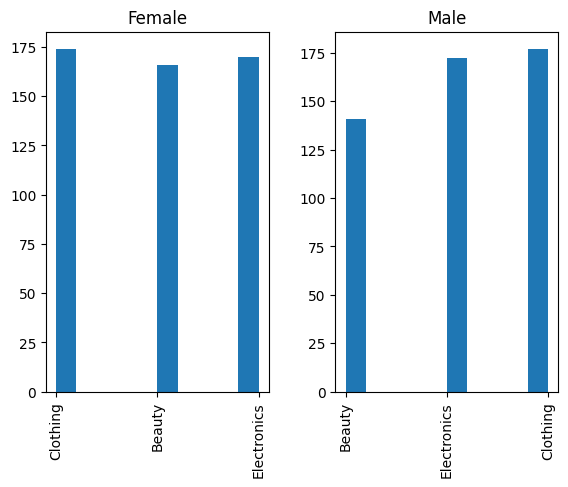

In [20]:
retail.hist(column='Product Category',by='Gender')

#Female histogram shows that there is no significant preference of purchase between different product categories
#For male there is a significant lesser preference for beauty products.

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

In [30]:
#User-Item matrix created in your example
user_item_matrix = retail.pivot_table(
    index='Customer ID',
    columns='Product Category',
    values='Total Amount',
    aggfunc='sum',
    fill_value=0
)


In [38]:
#Apply SVD for matrix factorization
svd = TruncatedSVD(n_components=3, random_state=42)  # 2 latent features
user_factors = svd.fit_transform(user_item_matrix)
item_factors = svd.components_

#Reconstruct the matrix (predicted values)
predicted_matrix = np.dot(user_factors, item_factors)
predicted_df = pd.DataFrame(predicted_matrix, index=user_item_matrix.index, columns=user_item_matrix.columns)
predicted_df.head()

Product Category,Beauty,Clothing,Electronics
Customer ID,,,
CUST001,150.0,0.0,0.0
CUST002,0.0,1000.0,0.0
CUST003,0.0,0.0,30.0
CUST004,0.0,500.0,0.0
CUST005,100.0,0.0,0.0


In [39]:
# Function to recommend top N products for a user
def recommend_products(user_id, user_item_matrix, predicted_df, top_n=3):
    user_idx = user_item_matrix.index.get_loc(user_id)
    user_scores = predicted_df.iloc[user_idx]
    already_purchased = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    recommendations = user_scores.drop(index=already_purchased).sort_values(ascending=False).head(top_n)
    return recommendations

# Example: Recommendations for 'CUST001'
recommendations = recommend_products('CUST001', user_item_matrix, predicted_df)
print(recommendations)


Product Category
Clothing       0.0
Electronics    0.0
Name: CUST001, dtype: float64


In [26]:
# Function to calculate Precision and Recall
def precision_recall_at_k(recommended_items, relevant_items, k):
    recommended_items_at_k = recommended_items[:k]
    relevant_items_set = set(relevant_items)

    # Precision
    precision = len(set(recommended_items_at_k) & relevant_items_set) / len(recommended_items_at_k)

    # Recall
    recall = len(set(recommended_items_at_k) & relevant_items_set) / len(relevant_items_set)

    return precision, recall

# Example usage
recommended_items = ['Beauty', 'Clothing', 'Electronics']  # Top N recommended items
relevant_items = ['Beauty', 'Clothing']  # Items the user actually interacted with
k = 3  # Top 3 recommended items

precision, recall = precision_recall_at_k(recommended_items, relevant_items, k)
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Precision: 0.6666666666666666
Recall: 1.0


In [27]:
def average_precision_at_k(recommended_items, relevant_items, k):
    recommended_items_at_k = recommended_items[:k]
    relevant_items_set = set(relevant_items)

    precision_at_k = []
    num_relevant = 0
    for i, item in enumerate(recommended_items_at_k):
        if item in relevant_items_set:
            num_relevant += 1
            precision_at_k.append(num_relevant / (i + 1))

    if precision_at_k:
        return np.mean(precision_at_k)
    else:
        return 0.0

def mean_average_precision(all_recommended_items, all_relevant_items, k):
    average_precisions = []
    for recommended_items, relevant_items in zip(all_recommended_items, all_relevant_items):
        average_precisions.append(average_precision_at_k(recommended_items, relevant_items, k))
    return np.mean(average_precisions)

# Example usage
all_recommended_items = [['Beauty', 'Clothing', 'Electronics'], ['Clothing', 'Electronics', 'Beauty']]
all_relevant_items = [['Beauty', 'Clothing'], ['Beauty', 'Electronics']]
k = 3

map_score = mean_average_precision(all_recommended_items, all_relevant_items, k)
print(f"MAP: {map_score}")


MAP: 0.7916666666666666


In [28]:
import numpy as np

def dcg_at_k(recommended_items, relevant_items, k):
    recommended_items_at_k = recommended_items[:k]
    relevant_items_set = set(relevant_items)

    dcg = 0
    for i, item in enumerate(recommended_items_at_k):
        if item in relevant_items_set:
            dcg += 1 / np.log2(i + 2)  # +2 because log is 1-indexed

    return dcg

def idcg_at_k(relevant_items, k):
    ideal_relevant_items = relevant_items[:k]
    return sum(1 / np.log2(i + 2) for i in range(len(ideal_relevant_items)))

def ndcg_at_k(recommended_items, relevant_items, k):
    dcg = dcg_at_k(recommended_items, relevant_items, k)
    idcg = idcg_at_k(relevant_items, k)
    if idcg == 0:
        return 0.0
    return dcg / idcg

# Example usage
recommended_items = ['Beauty', 'Clothing', 'Electronics']  # Top N recommended items
relevant_items = ['Beauty', 'Clothing']  # Items the user actually interacted with
k = 3  # Top 3 recommended items

ndcg = ndcg_at_k(recommended_items, relevant_items, k)
print(f"NDCG: {ndcg}")


NDCG: 1.0
